In [1]:
# установка стиля

#!pip install mplcyberpunk

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
from scipy.stats import kstest

In [3]:
# для первого запуска установить библиотеки:
# !pip install kaggle
# !pip install opendatasets

import opendatasets as od

dataset = 'https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset'
file = 'players_22.csv'

# загрузка датасета с kaggle
od.download(dataset)

Skipping, found downloaded files in ".\fifa-22-complete-player-dataset" (use force=True to force download)


In [4]:
cd

C:\Users\DNS


In [5]:
cd data_analyst_projects

C:\Users\DNS\data_analyst_projects


In [6]:
cd fifa-22-complete-player-dataset

C:\Users\DNS\data_analyst_projects\fifa-22-complete-player-dataset


In [7]:
df = pd.read_csv(file)

C:\Users\DNS\AppData\Local\Temp\ipykernel_7768\2131829638.py:1: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [8]:
# блок для использования результатов в блоге (матрица полей и их значений)

df_columns_types = pd.DataFrame()

column_count = 3

columns_types_dict = {column: df[column].dtype for column in df.columns}
for num in range(0, len(columns_types_dict), column_count):
    columns_types_dict_for_loop = dict(list(columns_types_dict.items())[num:num + column_count])
    columns_names = list(columns_types_dict_for_loop.keys())
    #columns_types = list(columns_types_dict_for_loop.values()) # планировал вывести типы, но потом подумал, что лучше пример
    try:
        matrix_columns_names = {num + 1: columns_names[num].upper() for num in range(column_count)}
        matrix_columns_sample = {num + 1: str(df[columns_names[num]][0])[:30] for num in range(column_count)}
    except:
        matrix_columns_names = {num + 1: columns_names[num].upper() for num in range(len(columns_types_dict_for_loop))}
        matrix_columns_sample = {num + 1: str(df[columns_names[num]][0])[:30] for num in range(len(columns_types_dict_for_loop))}
        
    df_columns_types = df_columns_types._append(matrix_columns_names, ignore_index=True)
    df_columns_types = df_columns_types._append(matrix_columns_sample, ignore_index=True)

def make_bold(val):
    return 'font-weight: bold'

if len(columns_types_dict) % column_count != 0:
    bold_raw = len(columns_types_dict) // column_count + 1
else:
    bold_raw = len(columns_types_dict) // column_count

df_columns_types = df_columns_types.style.applymap(
    make_bold, subset=pd.IndexSlice[range(0, (bold_raw * 2), 2), :])


In [9]:
# парсинг уникальных значений навыков (tags) и особенностей (traits), подсчёт кол-ва встречающихся признаков

def clean_marks(marks_list, tag): # функция парсинга
    output = []
    for mark in marks_list:
        if tag:
            mark = mark[mark.find('#') + 1:]
        output.append(mark.strip())
    return output    

players_tags = pd.DataFrame()
players_traits = pd.DataFrame() 

for string in df.itertuples(): # iteration by rows as turples
    player_tags = {}
    player_traits = {}
    player_id = string[1]
    player_tags['player_id'] = player_id
    player_traits['player_id'] = player_id    
    try:
        tags = clean_marks(string[36].split(','), tag = True) # 36 = tags
    except:
        tags = []
    try:
        traits = clean_marks(string[37].split(','), tag = False) # 37 = traits
    except:
        traits = []

    for tag in tags:
        player_tags[tag] = 1
    for trait in traits:
        player_traits[trait] = 1
    players_tags = players_tags._append(player_tags, ignore_index=True)
    players_traits = players_traits._append(player_traits, ignore_index=True)


In [10]:
# making one-hot-encoding

for column in players_tags.columns:
    if column != 'player_id':
        players_tags[column] = players_tags[column].fillna(0).astype('Int64')

for column in players_traits.columns:
    if column != 'player_id':
        players_traits[column] = players_traits[column].fillna(0).astype('Int64')
        

In [11]:
# creating data for corr mtrx

marks_corr_full = players_tags.merge(players_traits, 
                                how = 'outer', 
                                left_on='player_id', 
                                right_on='player_id').drop_duplicates()

for column in marks_corr_full.columns:
    if column != 'player_id':
        marks_corr_full[column] = marks_corr_full[column].fillna(0).astype('Int64')
        
marks_corr = marks_corr_full.drop('player_id', axis = 1)

player_club = df[['sofifa_id', 'club_name']]
marks_corr_full = marks_corr_full.merge(player_club, how = 'inner', 
                                left_on='player_id', 
                                right_on='sofifa_id').drop_duplicates()


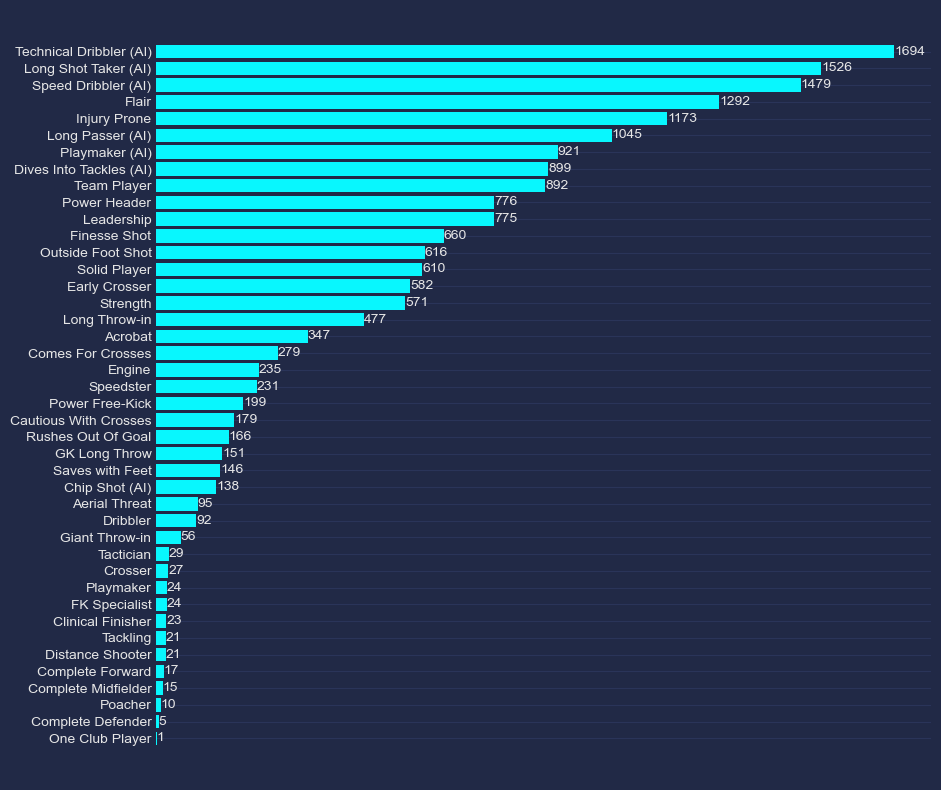

In [12]:
plt.style.use("cyberpunk")

fig, ax = plt.subplots(figsize=(10,10))
marks_corr_sum = pd.DataFrame(marks_corr[marks_corr.columns].agg('sum')).sort_values(by = 0)
bars = plt.barh(marks_corr_sum.index, marks_corr_sum[0])

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.bar_label(bars)

plt.show()

In [13]:
all_team_skills = pd.DataFrame(marks_corr_full.groupby('club_name')[marks_corr.columns].agg('sum'))

my_team_skills = pd.DataFrame()

for team in ['Paris Saint-Germain', 'FC Bayern München', 'Manchester City', 'FC Barcelona', 'Real Madrid CF', 'Liverpool']:
    team_skills = all_team_skills[all_team_skills.index == team]
    my_team_skills = pd.concat([my_team_skills, team_skills])


In [14]:
marks_corr_sum['pie'] = marks_corr_sum[0] / marks_corr_sum[0].sum()

skills_pie = marks_corr_sum.reset_index()

skills_metric_by_team = pd.DataFrame()

for index in my_team_skills.index:
    team_skills = my_team_skills[my_team_skills.index == index]
    team_top_skills = pd.DataFrame(team_skills.melt().sort_values(by = 'value').reset_index())
    team_top_skills = team_top_skills.drop('index', axis = 1)
    team = index
    team_top_skills['team'] = index
    team_top_skills = team_top_skills.merge(skills_pie, how = 'inner', left_on = 'variable', right_on = 'index')
    team_top_skills['metric'] = team_top_skills['value'] / team_top_skills['pie']
    if team == 'Paris Saint-Germain':
        team_top_skills = team_top_skills.sort_values(by = 'metric').iloc[38: 41].reset_index()
    else:
        team_top_skills = team_top_skills.sort_values(by = 'metric').iloc[39: 42].reset_index()
    skills_metric_by_team = pd.concat([skills_metric_by_team, team_top_skills])

In [15]:
skills_metric_by_team_pivoted = skills_metric_by_team.pivot(index = 'team', columns = 'variable', values = 'metric')

<Axes: xlabel='team'>

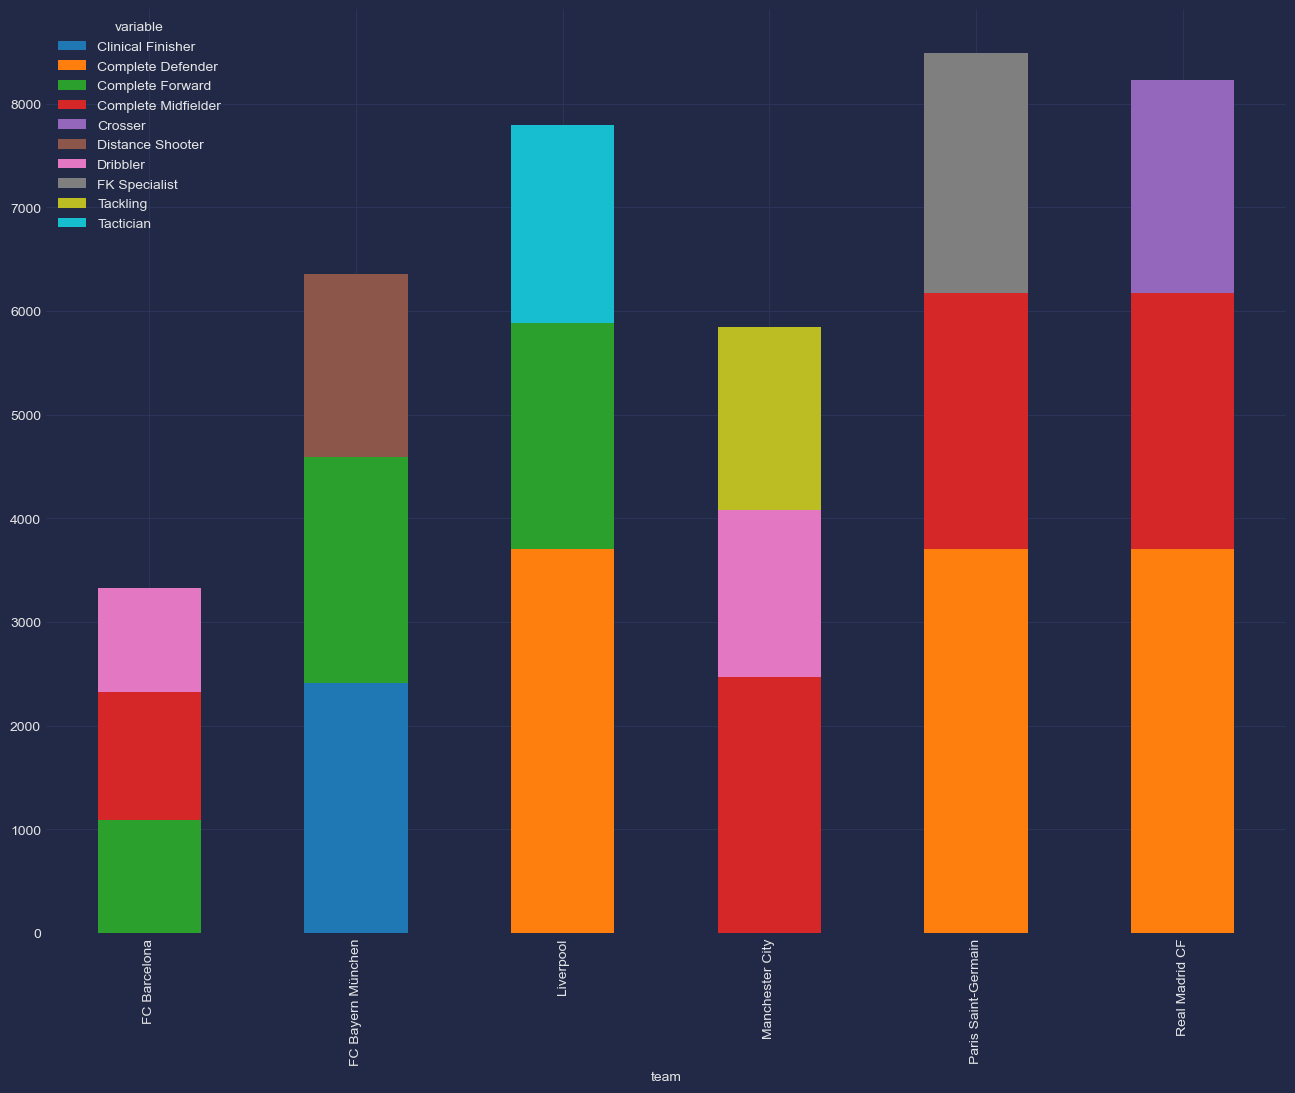

In [16]:
colors = plt.cm.tab10(np.linspace(0, 1, 10))
skills_metric_by_team_pivoted.plot(kind='bar', stacked= True, figsize=(16,12), color=colors)


In [17]:
skills_metric_by_team['metric'] = skills_metric_by_team['metric'].astype(dtype='float')

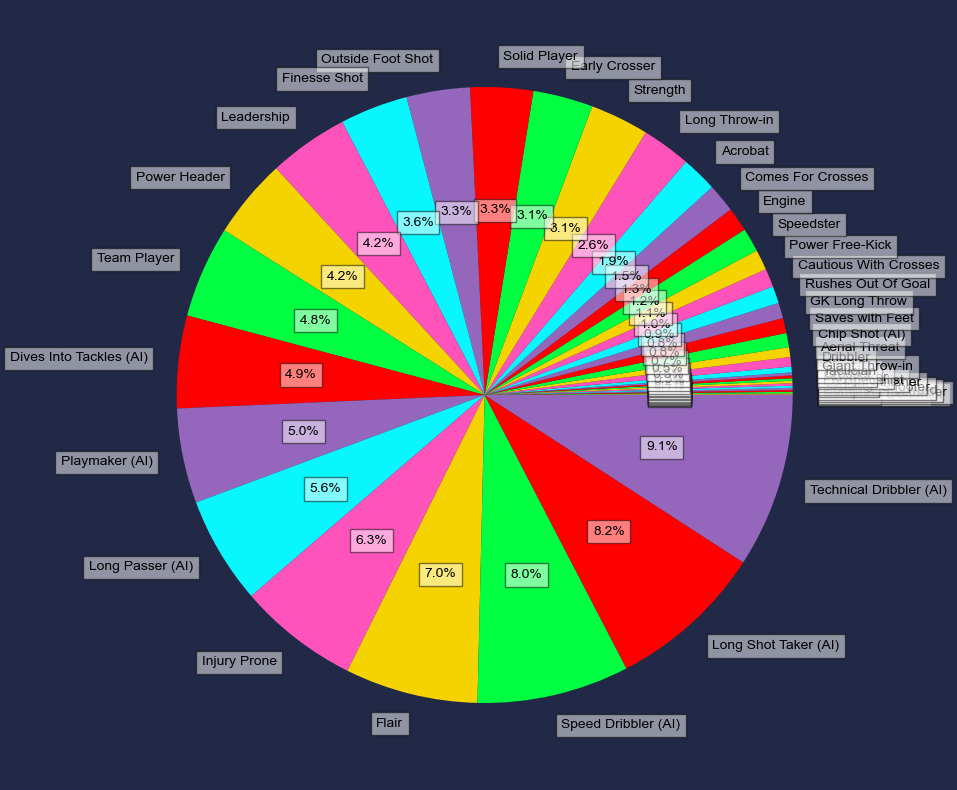

In [18]:
plt.style.use("cyberpunk")

fig, ax = plt.subplots(figsize=(10,10))
pie = plt.pie(marks_corr_sum[0].tolist(), labels = marks_corr_sum.index.tolist(), autopct='%1.1f%%', \
              textprops = {'color': 'black', 'bbox': {'color': 'white', 'alpha': 0.5, 'ec': 'black'}})

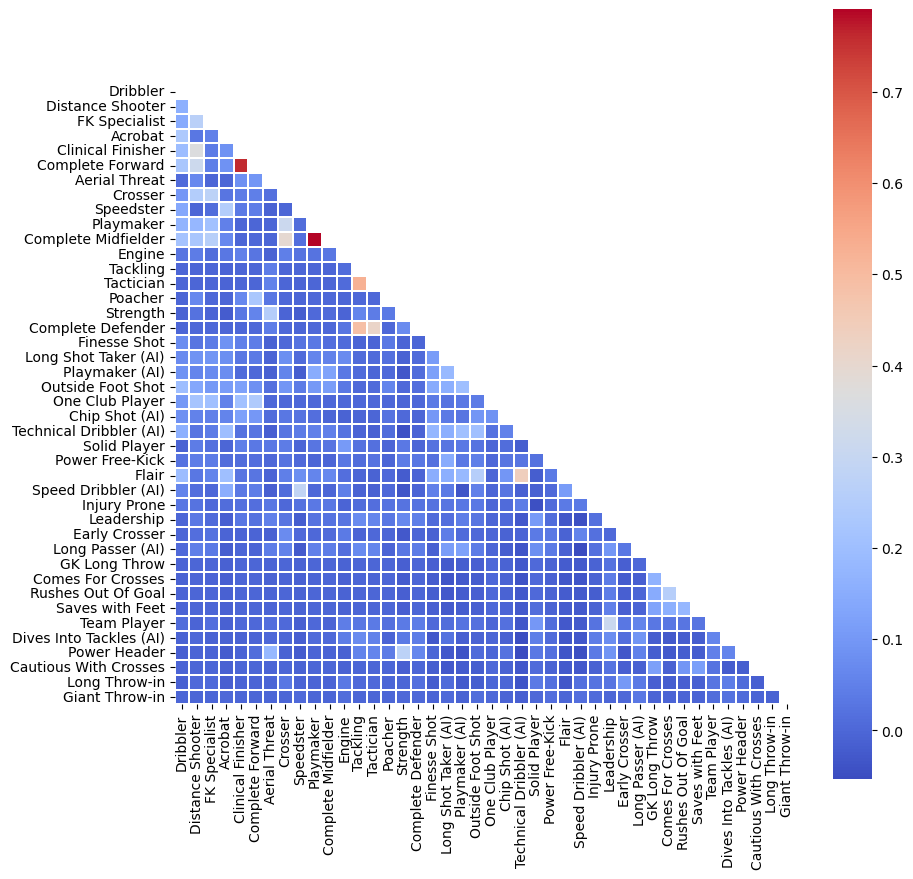

In [19]:
# heatmap of correlations

plt.style.use("default")

figsize = (10, 10)
matrix = np.triu(marks_corr.corr())
fig, ax = plt.subplots(figsize=figsize)
hmap = sns.heatmap(marks_corr.corr(), square=True, mask=matrix, linewidth=0.01, cmap= 'coolwarm')
plt.show()

<BarContainer object of 11 artists>

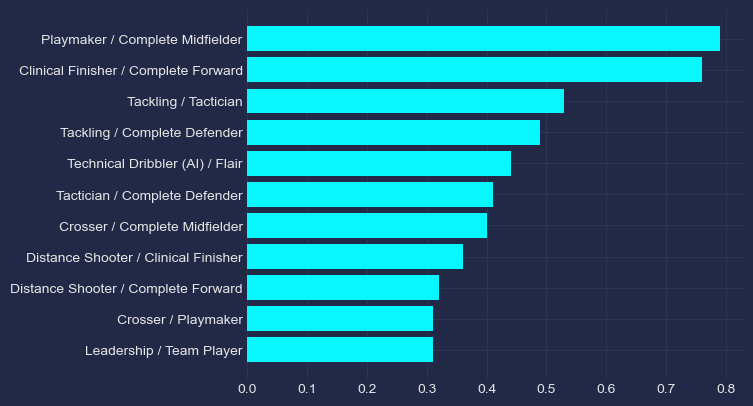

In [20]:
# finding highest correlations

plt.style.use("cyberpunk")
corr_data = marks_corr.corr()
h_corr = {}
marks_for_mean_wage = []

corrs = [(corr_data.loc[row, col], row, col) for row in corr_data.columns for col in corr_data.columns]
max_corr = sorted(corrs, key=lambda x: abs(x[0]), reverse=True)[42::2]
for corr in max_corr:
    if corr[0] >= 0.3:
        factors = corr[1] + ' / ' + corr[2]
        coef = round(corr[0], 2)
        h_corr[factors] = coef
        marks_for_mean_wage.append(corr[1])
        marks_for_mean_wage.append(corr[2])

        

factors = list(h_corr.keys())
factors.reverse()
coef = list(h_corr.values())
coef.reverse()

plt.barh(factors, coef)

In [21]:
# marks with highest wage

marks_list = players_tags.columns.tolist()[1:] + players_traits.columns.tolist()[1:]
marks_mean_wage = {}

for mark in marks_list:
    mark_wages = []
    mark_names = []
    for string in df.itertuples():
        try:
            tags_count = len(clean_marks(string[36].split(','), tag = True))
        except:
            tags_count = 0
        try:
            traits_count = len(clean_marks(string[37].split(','), tag = False))
        except:
            traits_count = 0
        marks_count = tags_count + traits_count
        if (string[36] is not np.nan and mark in string[36]) or (string[37] is not np.nan and mark in string[37]):
            coef = float(string[9] / marks_count / string[6] * string[17] / string[31])
            mark_wages.append(coef)
            mark_names.append(string[3])
    mark_mean = pd.Series(mark_wages).mean()
    marks_mean_wage[mark] = mark_mean
    
marks_mean_wage = pd.Series(marks_mean_wage).to_frame()
marks_mean_wage = marks_mean_wage.sort_values(by = 0)
marks_mean_wage = marks_mean_wage.reset_index()

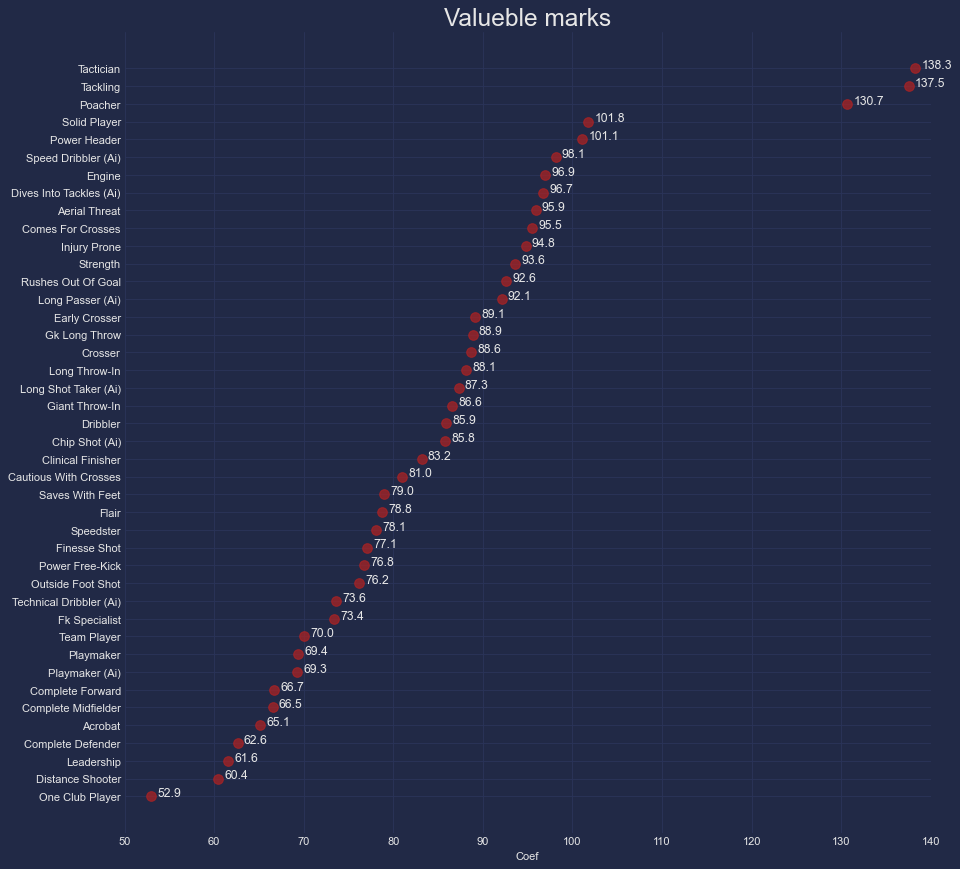

In [22]:

fig, ax = plt.subplots(figsize=(13, 13), dpi= 80)
ax.hlines(y=marks_mean_wage.index, xmin=11, xmax=26, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=marks_mean_wage.index, x=marks_mean_wage[0], s=75, color='firebrick', alpha=0.7)

ax.set_title('Valueble marks', fontdict={'size':22})
ax.set_xlabel('Coef')
ax.set_yticks(marks_mean_wage.index)
[plt.text(i + 0.7, j, f'{round(i, 1)}', fontdict={'size':11}) for (i, j) in zip(marks_mean_wage[0], marks_mean_wage.index)]
ax.set_yticklabels(marks_mean_wage['index'].str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(50, 140)
plt.show()